# Neural Autoregressive Density Estimator

In this exercise we'll implement the Neural Autoregressive Density Estimator (NADE): http://jmlr.csail.mit.edu/proceedings/papers/v15/larochelle11a/larochelle11a.pdf. 

Study algorithm 1 in the article to understand the implementation. Also watch this presentation for a good introduction:
http://videolectures.net/aistats2011_larochelle_neural/.

In [ ]:
import theano
theano.config.floatX = 'float32'
import theano.tensor as T
from theano.tensor.shared_randomstreams import RandomStreams
import lasagne
from lasagne.updates import sgd
from lasagne.layers import InputLayer, get_all_params, base
from lasagne.nonlinearities import sigmoid
import numpy as np

First we'll implementat a new Lasagne layer, the NADELayer. The layer will be implemented with untied weights $W$ and $V$ with corresponding biases $b$ and $c$. The exercise is to implement the reconstruct, negative log likelihood and the sample function.

In [ ]:
class NADELayer(base.Layer):
    def __init__(self, incoming, n_hidden, trans_func, **kwargs):
        super(NADELayer, self).__init__(incoming, **kwargs)
        self._srng = RandomStreams()
        self.n_in = incoming.output_shape[-1]
        self.n_hidden = n_hidden
        self.trans_func = trans_func
        init_W = ((2 * np.random.normal(size=(self.n_in, n_hidden)) - 1) / self.n_in).astype(theano.config.floatX)
        self.W = self.add_param(init_W, (self.n_in, self.n_hidden), name="W")
        init_V = ((2 * np.random.normal(size=(n_hidden, self.n_in)) - 1) / self.n_in).astype(theano.config.floatX)
        self.V = self.add_param(init_V, (self.n_hidden, self.n_in), name="V")
        self.b = self.add_param(lasagne.init.Constant(0.), (self.n_in,), name="b")
        self.c = self.add_param(lasagne.init.Constant(0.), (self.n_hidden,), name="c")

        self.W_params = [self.W, self.V]
        self.bias_params = [self.b, self.c]

        self.params = [self.W, self.b, self.V, self.c]

    def get_params(self):
        return self.params

    def reconstruct(self, x):
        # TODO: Write the forward and backward pass for the NADE. Return the probabilities.
        rep_X = (x.dimshuffle(0, 'x', 1) * T.ones((x.shape[1], x.shape[1])) *
             np.asarray(np.tril(np.ones((self.n_in, self.n_in)), k=-1), dtype=theano.config.floatX))

        h = self.trans_func(T.dot(rep_X, self.W) + self.c)
        p = self.trans_func((self.V.T * h).sum(axis=2) + self.b)
        return p

    def negative_log_likelihood(self, x):
        p = self.reconstruct(x)
        # TODO: Write the expression for the negative log likelihood and return.
        return (x * T.log(p) + (1 - x) * T.log(1 - p)).sum(axis=1)

    def sample(self, num_samples):
        a_acc = T.zeros((num_samples, self.n_hidden), dtype=theano.config.floatX) + self.c
        p_acc = T.zeros((num_samples,), dtype=theano.config.floatX)
        v_acc = T.zeros((num_samples,), dtype=theano.config.floatX)
        log_likelihood_acc = T.zeros((num_samples,), dtype=theano.config.floatX)
        
        # TODO: Write the sampling function according to algorithm 1 in the article.
        # Return the reconstructed binary units.
        def one_iter(W_i, V_i, b_i, a, v_lt_i, p_lt_i, log_likelihood):
            h_i = self.trans_func(a)
            p_i = self.trans_func(T.dot(h_i, V_i) + b_i)
            v_i = 1. * (self._srng.uniform([num_samples]) <= p_i)
            log_likelihood += v_i * T.log(p_i) + (1 - v_i) * T.log(1 - p_i)
            a += T.outer(v_i, W_i)
            return a, v_i, p_i, log_likelihood

        [a, v, p, log_likelihood], updates = theano.scan(
            fn=one_iter,
            sequences=[self.W, self.V.T, self.b],
            outputs_info=[a_acc, v_acc, p_acc, log_likelihood_acc]
        )

        return v.T

Next we'll define the model that will build the layer architecture and the theano functions for training.

In [26]:
class NADE:
    def __init__(self, n_in, n_hidden, trans_func=sigmoid, batch_size=100):
        self.batch_size = batch_size
        self._srng = RandomStreams()
        l_in = InputLayer((batch_size, n_in))
        self.model = NADELayer(l_in, n_hidden, trans_func)
        self.x = T.matrix('x')

    def build_model(self, train_x, test_x, valid_x, update_func, update_args):
        self.train_x = train_x
        self.test_x = test_x
        self.validation_x = valid_x
        self.index = T.iscalar('index')
        self.batch_slice = slice(self.index * self.batch_size, (self.index + 1) * self.batch_size)
        
        x = self._srng.binomial(size=self.x.shape, n=1, p=self.x, dtype=theano.config.floatX)
        loss = self.model.negative_log_likelihood(x)
        updates = update_func(-loss.mean(), get_all_params(self.model), *update_args)

        train_model = theano.function([self.index], loss, updates=updates,
                                      givens={self.x: self.train_x[self.batch_slice], }, )

        test_model = theano.function([self.index], loss,
                                     givens={self.x: self.test_x[self.batch_slice], }, )

        validate_model = theano.function([self.index], loss,
                                         givens={self.x: self.validation_x[self.batch_slice], }, )
        
        return train_model, test_model, validate_model

    def get_output(self, dat):
        return self.model.reconstruct(dat)

    def sample(self, num_samples):
        return self.model.sample(num_samples)

The training of NADE can be quite time consuming. So we'll implement the ability to only train on a subset of digits/classes.

In [30]:
from random import shuffle
def load_mnist(keep_classes=2):

    def minimize_mnist(x, y, keep_classes, n_classes=10):
        def _split_by_class(x, y, n):
            result_x = [0]*n
            result_y = [0]*n
            for i in range(n):
                idx_i = np.where(y == i)[0]
                result_x[i] = x[:,idx_i]
                result_y[i] = y[idx_i]
            return result_x, result_y
        
        def _collect(x, y, n_classes):
            x_new = [0]*n_classes
            y_new = [0]*n_classes
            for i in range(n_classes):
                idx = range(x[i].shape[1])
                shuffle(idx)
                x_new[i] = x[i][:, idx]
                y_new[i] = y[i][:, idx]
            return np.hstack(x_new).T, np.hstack(y_new).T

        x, y = _split_by_class(x.T, y.T, n_classes)
        def binarize_labels(y, n_classes=10):
            new_y = np.zeros((n_classes, y.shape[0]))
            for i in range(y.shape[0]):
                new_y[y[i], i] = 1
            return new_y
        for i in range(n_classes):
            y[i] = binarize_labels(y[i])
        x = x[:keep_classes]
        y = y[:keep_classes]
        x, y = _collect(x,y, keep_classes)
        return x, y
        
    data = np.load('mnist.npz')
    num_classes = 10
    x_train, targets_train = minimize_mnist(data['X_train'].astype('float32'), data['y_train'], keep_classes)
    x_valid, targets_valid = minimize_mnist(data['X_valid'].astype('float32'), data['y_valid'], keep_classes)
    x_test, targets_test = minimize_mnist(data['X_test'].astype('float32'), data['y_test'], keep_classes)


    def shared_dataset(x, y, borrow=True):
        shared_x = theano.shared(np.asarray(x, dtype=theano.config.floatX), borrow=borrow)
        shared_y = theano.shared(np.asarray(y, dtype=theano.config.floatX), borrow=borrow)
        return shared_x, shared_y

    return shared_dataset(x_train, targets_train), shared_dataset(x_test, targets_test), shared_dataset(x_valid, targets_valid)


(train_x, train_t), (test_x, test_t), (valid_x, valid_t) = load_mnist(1)

Run the training loop. Experiment with different hyperparameters.

In [31]:
import time
batch_size = 100
n_epochs = 10
eval_train = {}
eval_test = {}
eval_valid = {}
n_train_batches = train_x.get_value(borrow=True).shape[0] / batch_size
n_test_batches = test_x.get_value(borrow=True).shape[0] / batch_size
n_valid_batches = valid_x.get_value(borrow=True).shape[0] / batch_size

model = NADE(784, 500, trans_func=sigmoid, batch_size=100)
train_model, test_model, valid_model = model.build_model(train_x, test_x, valid_x, sgd, update_args=(1e-2,))

for epoch in range(n_epochs):
    start_time = time.time()
    epoch += 1
    avg_costs = []
    for minibatch_index in xrange(n_train_batches):
        minibatch_avg_cost = train_model(minibatch_index)
        avg_costs.append(minibatch_avg_cost)
    eval_train[epoch] = np.mean(avg_costs)
    test_losses = [test_model(i) for i in xrange(n_test_batches)]
    valid_losses = [valid_model(i) for i in xrange(n_valid_batches)]
    eval_test[epoch] = np.mean(test_losses)
    eval_valid[epoch] = np.mean(valid_losses)
    end_time = time.time() - start_time
    print "[epoch,time,train,valid,test];%i;%.2f;%.10f;%.10f;%.10f" % (epoch, end_time, eval_train[epoch], eval_valid[epoch], eval_test[epoch])

[epoch,time,train,valid,test];1;123.92;-229.8040771484;-202.7562103271;-203.8803863525
[epoch,time,train,valid,test];2;124.20;-205.2146759033;-200.2232513428;-201.5931549072
[epoch,time,train,valid,test];3;122.28;-203.7693939209;-199.4363708496;-200.4618682861
[epoch,time,train,valid,test];4;118.35;-203.0816345215;-198.7542114258;-200.1326751709
[epoch,time,train,valid,test];5;115.25;-202.2997436523;-197.9929962158;-199.2351379395
[epoch,time,train,valid,test];6;119.42;-201.0495452881;-195.8755950928;-197.1438598633
[epoch,time,train,valid,test];7;113.78;-198.0149536133;-191.9122161865;-193.7437133789
[epoch,time,train,valid,test];8;114.15;-193.2810516357;-186.7675170898;-188.7739257812
[epoch,time,train,valid,test];9;119.76;-188.1879577637;-182.4052124023;-184.9211120605
[epoch,time,train,valid,test];10;115.34;-184.1262969971;-178.0600738525;-180.9349975586


Plot a sample and the error for training, testing and validation.

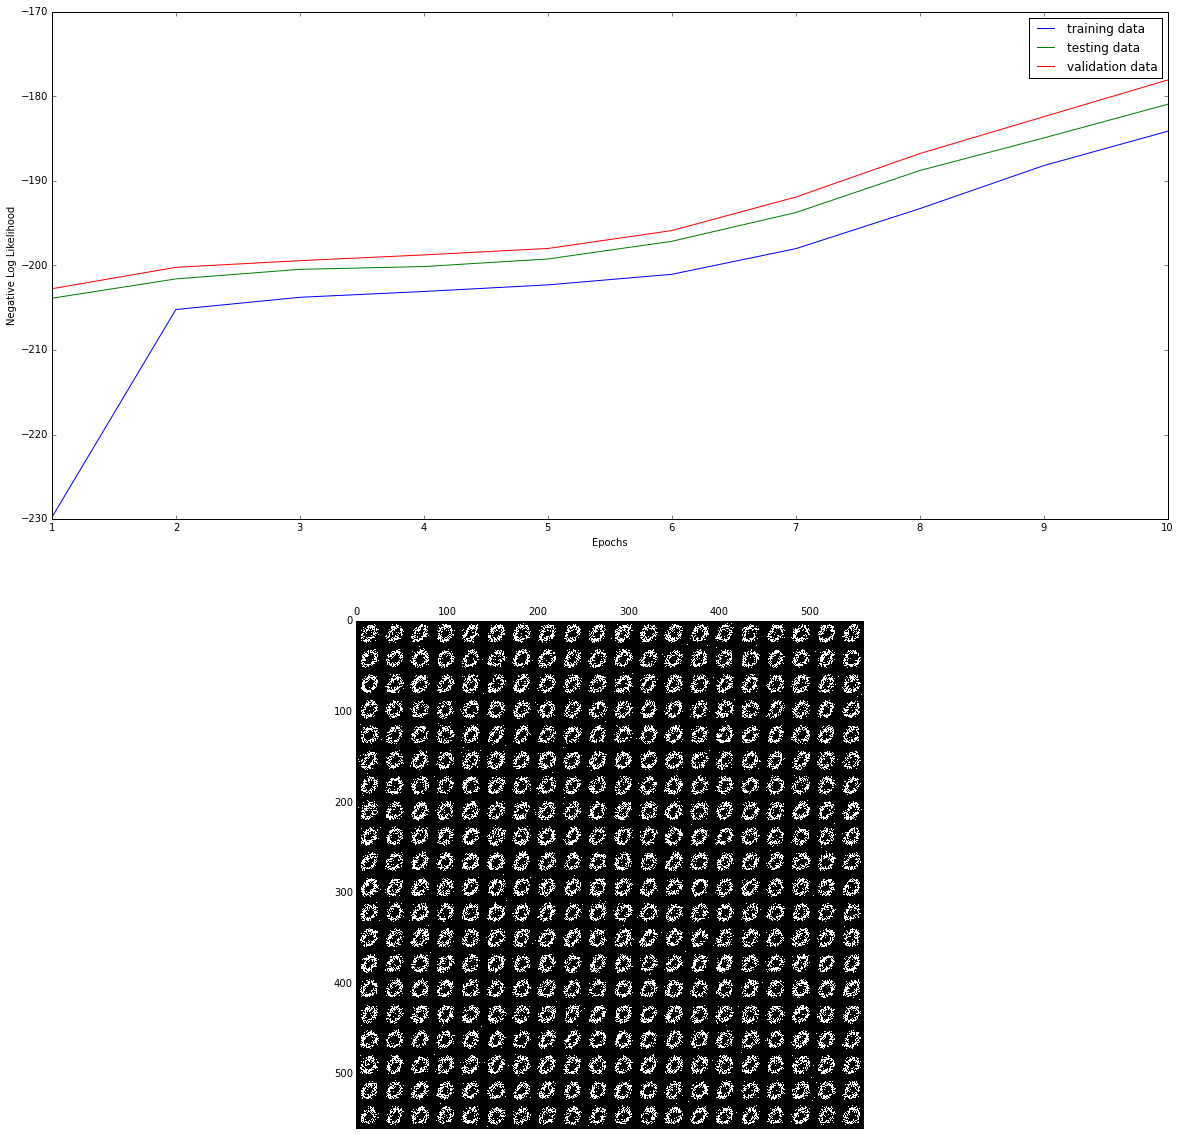

In [33]:
import matplotlib.pyplot as plt # Plotting library.
import matplotlib
%matplotlib inline

fig = plt.figure(figsize=(20,20))
sp = plt.subplot(211)
sp.plot(eval_train.keys(), eval_train.values(), label='training data')
sp.plot(eval_test.keys(), eval_test.values(), label='testing data')
sp.plot(eval_valid.keys(), eval_valid.values(), label='validation data')
plt.legend()
plt.ylabel("Negative Log Likelihood")
plt.xlabel('Epochs')

images = model.sample(400).eval()
sp = plt.subplot(212)
i = 0
img_out = np.zeros((28 * 20, 28 * 20))
for x in range(20):
    for y in range(20):
        xa, xb = x * 28, (x + 1) * 28
        ya, yb = y * 28, (y + 1) * 28
        im = np.reshape(images[i], (28, 28))
        img_out[xa:xb, ya:yb] = im
        i += 1
sp.matshow(img_out, cmap='gray')
plt.show()